✅ 数据读取成功！
数据清洗完成，剩余 1895 条有效记录。

===== 1.1 各国地震死亡总人数 Top 10 =====
Country
CHINA           2049509.0
TURKEY           713726.0
IRAN             624312.0
HAITI            323782.0
JAPAN            314031.0
ITALY            300894.0
INDONESIA        279704.0
PAKISTAN         143350.0
ECUADOR          129445.0
TURKMENISTAN     110412.0 

===== 1.2 每年震级 > 6.0 的地震次数 =====



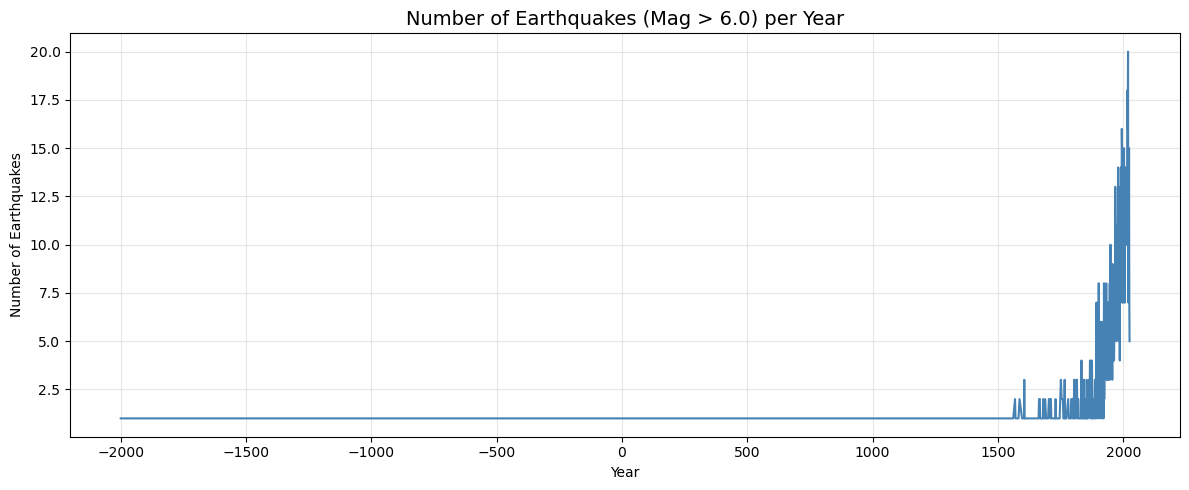

===== 1.3 各国地震总数与最大地震信息 =====



C:\Users\xiezhengyang\AppData\Local\Temp\ipykernel_2428\535772882.py:91: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = result_df.style.applymap(highlight_max_magnitude, subset=['Max_Magnitude']) \
C:\Users\xiezhengyang\AppData\Local\Temp\ipykernel_2428\535772882.py:92: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_top_deaths, subset=['Total_Deaths']) \


,Total_Count,Max_Magnitude,Max_Date,Total_Deaths,Region,Location
CHINA,267,8.500000,1668-07-25,42578.000000,30.000000,CHINA: SHANDONG PROVINCE
INDONESIA,158,9.100000,2004-12-26,227899.000000,60.000000,INDONESIA: SUMATRA: ACEH: OFF WEST COAST
IRAN,148,7.900000,0856-12-22,200000.000000,140.000000,"IRAN: DAMGHAN, QUMIS"
JAPAN,117,9.100000,2011-03-11,18428.000000,30.000000,JAPAN: HONSHU
TURKEY,107,7.800000,1939-12-26,32700.000000,140.000000,TURKEY: ERZINCAN
PERU,82,8.600000,1619-02-14,350.000000,160.000000,"PERU: TRUJILLO, PIURA, SANTA"
GREECE,67,8.000000,0365-07-21,5000.000000,130.000000,GREECE: CRETE: KNOSSOS
MEXICO,66,8.600000,1787-03-28,11.000000,150.000000,"MEXICO: SAN MARCOS, OAXACA"
TAIWAN,66,8.200000,1920-06-05,5.000000,30.000000,TAIWAN
PHILIPPINES,61,8.700000,1897-09-21,13.000000,170.000000,"PHILIPPINES: MINDANAO, ZAMBOANGA, SULU, ISABELA"


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1. 读取并预处理数据
# -------------------------
file_path = r"C:\Users\xiezhengyang\Desktop\earthquakes-2025-10-29_21-04-53_+0800.tsv"

Sig_Eqs = pd.read_csv(file_path, sep='\t', low_memory=False)
print("✅ 数据读取成功！")

# 检查关键列
required_cols = ['Year', 'Mo', 'Dy', 'Country', 'Mag', 'Total Deaths', 'Region', 'Location Name']
for col in required_cols:
    if col not in Sig_Eqs.columns:
        Sig_Eqs[col] = None

Sig_Eqs = Sig_Eqs.dropna(subset=['Year', 'Country', 'Mag', 'Total Deaths'])
Sig_Eqs['Year'] = Sig_Eqs['Year'].astype(int)

print(f"数据清洗完成，剩余 {len(Sig_Eqs)} 条有效记录。\n")

# -------------------------
# 1.1 各国地震死亡总数 Top 10
# -------------------------
deaths_by_country = (
    Sig_Eqs.groupby('Country')['Total Deaths']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print("===== 1.1 各国地震死亡总人数 Top 10 =====")
print(deaths_by_country.to_string(), "\n")

# -------------------------
# 1.2 每年震级 > 6.0 的地震次数
# -------------------------
eqs_gt6 = Sig_Eqs[Sig_Eqs['Mag'] > 6.0]
eqs_per_year = eqs_gt6.groupby('Year').size()

print("===== 1.2 每年震级 > 6.0 的地震次数 =====\n")
plt.figure(figsize=(12, 5))
plt.plot(eqs_per_year.index, eqs_per_year.values, color='steelblue', linewidth=1.5)
plt.title("Number of Earthquakes (Mag > 6.0) per Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Number of Earthquakes")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# -------------------------
# 1.3 各国地震总数与最大地震信息（格式化 YYYY-MM-DD，高亮）
# -------------------------
def CountEq_LargestEq(country):
    sub_df = Sig_Eqs[Sig_Eqs['Country'] == country]
    total_count = sub_df.shape[0]
    max_eq = sub_df.loc[sub_df['Mag'].idxmax()]

    year = int(max_eq['Year'])
    month = int(max_eq['Mo']) if pd.notna(max_eq['Mo']) else 1
    day = int(max_eq['Dy']) if pd.notna(max_eq['Dy']) else 1
    date_str = f"{year:04d}-{month:02d}-{day:02d}"

    return {
        'Total_Count': total_count,
        'Max_Magnitude': max_eq['Mag'],
        'Max_Date': date_str,
        'Total_Deaths': max_eq['Total Deaths'],
        'Region': max_eq['Region'] if pd.notna(max_eq['Region']) else '',
        'Location': max_eq['Location Name'] if pd.notna(max_eq['Location Name']) else ''
    }

countries = Sig_Eqs['Country'].unique()
result_df = pd.DataFrame([CountEq_LargestEq(c) for c in countries], index=countries)
result_df = result_df.sort_values(by='Total_Count', ascending=False)

# -------------------------
# 高亮函数
# -------------------------
def highlight_max_magnitude(val):
    color = 'background-color: yellow' if val == result_df['Max_Magnitude'].max() else ''
    return color

def highlight_top_deaths(val):
    color = 'background-color: lightcoral' if val >= result_df['Total_Deaths'].max() else ''
    return color

# 输出带高亮的表格（Jupyter Notebook）
print("===== 1.3 各国地震总数与最大地震信息 =====\n")
styled_df = result_df.style.applymap(highlight_max_magnitude, subset=['Max_Magnitude']) \
                           .applymap(highlight_top_deaths, subset=['Total_Deaths']) \
                           .set_caption("各国地震总数与最大地震信息（高亮）")
display(styled_df)


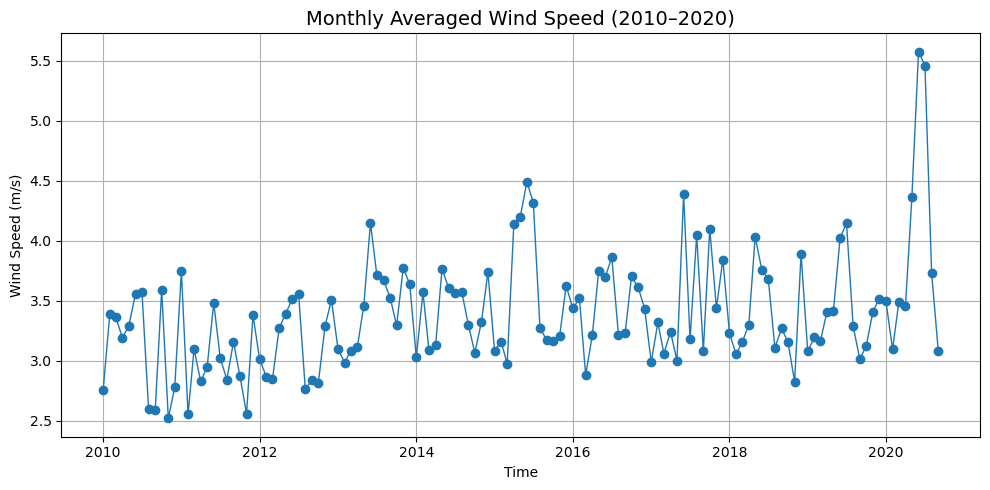

风速整体呈上升趋势（相关系数: 0.37）


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. 读取数据 ===
file_path = r"C:\Users\xiezhengyang\Desktop\2281305.csv"
df = pd.read_csv(file_path, sep=None, engine='python')

# === 2. 解析日期 ===
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

# === 3. 从 WND 列提取风速 ===
# 格式示例："040,1,N,0020,1"
# 通常风速在第4个逗号分隔的部分
def extract_speed(wnd_str):
    try:
        parts = wnd_str.split(',')
        if len(parts) >= 4:
            val = parts[3]
            if val != '9999':  # 9999 表示缺失
                return float(val) / 10.0  # 风速单位为 m/s（存储为十分之一）
    except:
        return None
    return None

df['wind_speed'] = df['WND'].apply(extract_speed)

# === 4. 删除缺失风速 ===
df = df.dropna(subset=['wind_speed'])

# === 5. 取 2010–2020 年的数据 ===
df = df[(df['DATE'].dt.year >= 2010) & (df['DATE'].dt.year <= 2020)]

# === 6. 按月计算平均风速 ===
df['YearMonth'] = df['DATE'].dt.to_period('M')
monthly_avg = df.groupby('YearMonth')['wind_speed'].mean().reset_index()
monthly_avg['YearMonth'] = monthly_avg['YearMonth'].dt.to_timestamp()

# === 7. 绘制趋势图 ===
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg['YearMonth'], monthly_avg['wind_speed'], marker='o', linewidth=1)
plt.title("Monthly Averaged Wind Speed (2010–2020)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Wind Speed (m/s)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 8. 输出简单趋势判断 ===
corr = monthly_avg['YearMonth'].map(pd.Timestamp.toordinal).corr(monthly_avg['wind_speed'])
if corr > 0:
    print(f"风速整体呈上升趋势（相关系数: {corr:.2f}）")
elif corr < 0:
    print(f"风速整体呈下降趋势（相关系数: {corr:.2f}）")
else:
    print("风速整体没有明显趋势。")


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

CSV_PATH = r"C:\Users\xiezhengyang\Desktop\全国主要城市空气质量.csv"
# 输出目录（默认与CSV同目录下）
OUT_DIR = None               # None 表示自动在CSV旁创建 “空气质量_每城报告”
ENCODING = "gbk"             # 常见国标编码
DATE_COL = "日期"
CITY_COL = "城市"
QUALITY_COL = "质量等级"

# 参与统计的数值列（按文件列名）
NUM_COLS = ["AQI指数", "当天AQI排名", "PM2.5", "PM10", "So2", "No2", "Co", "O3"]

# 基础作图变量（每城默认作图用PM2.5 & AQI指数）
TS_VAR_1 = "PM2.5"
TS_VAR_2 = "AQI指数"

# 可选：是否做IQR异常值裁剪（仅用于统计，不改原始时序图）
USE_IQR_CLIP = False
IQR_FACTOR = 3.0   # 常用1.5或3.0
# =================================================

# ----- Matplotlib中文字体设置 -----
matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'Noto Sans CJK SC']
matplotlib.rcParams['axes.unicode_minus'] = False

def ensure_outdir(base_csv_path):
    base_dir = os.path.dirname(base_csv_path)
    out_dir = os.path.join(base_dir, "空气质量_每城报告") if OUT_DIR is None else OUT_DIR
    os.makedirs(out_dir, exist_ok=True)
    return out_dir

def sanitize_name(name):
    # 文件夹/文件名安全化
    return re.sub(r'[\\/:*?"<>|]+', "_", str(name))

def to_datetime_safe(s):
    return pd.to_datetime(s, errors='coerce', infer_datetime_format=True)

def numericize(df, cols):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def iqr_clip(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lo = q1 - factor * iqr
    hi = q3 + factor * iqr
    return series.clip(lower=lo, upper=hi)

def compute_stats(series):
    # 返回常用统计指标
    s = series.dropna()
    res = {
        "count": s.size,
        "mean": s.mean(),
        "median": s.median(),
        "std": s.std(ddof=1),
        "min": s.min(),
        "p05": s.quantile(0.05),
        "p25": s.quantile(0.25),
        "p75": s.quantile(0.75),
        "p95": s.quantile(0.95),
        "max": s.max(),
        "skew": s.skew(),
        "kurt": s.kurt(),
        "missing_rate": 1 - (s.size / series.size if series.size else np.nan)
    }
    return res

def plot_time_series(df_city, var, out_png):
    # 单图：时间序列 + 7日滑动均值
    plt.figure(figsize=(12, 5))
    plt.plot(df_city[DATE_COL], df_city[var], linewidth=1, label=f"{var} (daily)")
    if df_city[var].notna().sum() >= 7:
        ma = df_city[var].rolling(window=7, min_periods=1).mean()
        plt.plot(df_city[DATE_COL], ma, linewidth=2, label=f"{var} 7日滑动均值")
    plt.title(f"{df_city[CITY_COL].iloc[0]} - {var} 时间序列")
    plt.xlabel("日期")
    plt.ylabel(var)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

def plot_hist(df_city, var, out_png):
    plt.figure(figsize=(8, 5))
    plt.hist(df_city[var].dropna(), bins=30)
    plt.title(f"{df_city[CITY_COL].iloc[0]} - {var} 直方图")
    plt.xlabel(var)
    plt.ylabel("频数")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

def plot_box(df_city, var, out_png):
    plt.figure(figsize=(6, 5))
    plt.boxplot(df_city[var].dropna(), vert=True, patch_artist=False, showfliers=True)
    plt.title(f"{df_city[CITY_COL].iloc[0]} - {var} 箱线图")
    plt.ylabel(var)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

def city_monthly_tables(df_city):
    # 生成月度统计表（均值/中位/最大/最小），按NUM_COLS列
    d = df_city.copy()
    d["年月"] = d[DATE_COL].dt.to_period("M").astype(str)
    monthly_mean = d.groupby("年月")[NUM_COLS].mean(numeric_only=True)
    monthly_median = d.groupby("年月")[NUM_COLS].median(numeric_only=True)
    monthly_max = d.groupby("年月")[NUM_COLS].max(numeric_only=True)
    monthly_min = d.groupby("年月")[NUM_COLS].min(numeric_only=True)
    return monthly_mean, monthly_median, monthly_max, monthly_min

def analyze_one_city(df_city, base_out_dir):
    city_name = sanitize_name(df_city[CITY_COL].iloc[0])
    city_dir = os.path.join(base_out_dir, city_name)
    os.makedirs(city_dir, exist_ok=True)

    # 统计用的数据（可选：IQR裁剪，仅影响统计，不影响时序图）
    df_stats = df_city.copy()
    if USE_IQR_CLIP:
        for col in NUM_COLS:
            if col in df_stats.columns:
                df_stats[col] = iqr_clip(df_stats[col], IQR_FACTOR)

    # 统计指标表
    rows = []
    for col in NUM_COLS:
        if col in df_stats.columns:
            stat = compute_stats(df_stats[col])
            stat["metric"] = col
            rows.append(stat)
    stats_df = pd.DataFrame(rows).set_index("metric")
    stats_path = os.path.join(city_dir, f"{city_name}_统计指标.csv")
    stats_df.to_csv(stats_path, encoding="utf-8-sig")

    # 质量等级分布
    qual_counts = df_city[QUALITY_COL].value_counts(dropna=False).rename("count")
    qual_rate = (qual_counts / qual_counts.sum()).rename("rate")
    quality_df = pd.concat([qual_counts, qual_rate], axis=1)
    quality_path = os.path.join(city_dir, f"{city_name}_质量等级分布.csv")
    quality_df.to_csv(quality_path, encoding="utf-8-sig")

    # 月度表
    monthly_mean, monthly_median, monthly_max, monthly_min = city_monthly_tables(df_city)
    monthly_mean.to_csv(os.path.join(city_dir, f"{city_name}_月度_均值.csv"), encoding="utf-8-sig")
    monthly_median.to_csv(os.path.join(city_dir, f"{city_name}_月度_中位数.csv"), encoding="utf-8-sig")
    monthly_max.to_csv(os.path.join(city_dir, f"{city_name}_月度_最大值.csv"), encoding="utf-8-sig")
    monthly_min.to_csv(os.path.join(city_dir, f"{city_name}_月度_最小值.csv"), encoding="utf-8-sig")

    # 作图：时间序列（PM2.5 & AQI指数），直方图/箱线图（PM2.5）
    if TS_VAR_1 in df_city.columns:
        plot_time_series(df_city, TS_VAR_1, os.path.join(city_dir, f"{city_name}_时间序列_{TS_VAR_1}.png"))
        plot_hist(df_city, TS_VAR_1, os.path.join(city_dir, f"{city_name}_直方图_{TS_VAR_1}.png"))
        plot_box(df_city, TS_VAR_1, os.path.join(city_dir, f"{city_name}_箱线图_{TS_VAR_1}.png"))
    if TS_VAR_2 in df_city.columns:
        plot_time_series(df_city, TS_VAR_2, os.path.join(city_dir, f"{city_name}_时间序列_{TS_VAR_2}.png"))

    # 返回用于汇总的关键信息（比如PM2.5均值、AQI均值等）
    ret = {
        "城市": df_city[CITY_COL].iloc[0],
        "样本数": len(df_city),
        "PM2.5_mean": stats_df.loc[TS_VAR_1, "mean"] if TS_VAR_1 in stats_df.index else np.nan,
        "AQI_mean": stats_df.loc["AQI指数", "mean"] if "AQI指数" in stats_df.index else np.nan,
        "PM10_mean": stats_df.loc["PM10", "mean"] if "PM10" in stats_df.index else np.nan,
        "O3_mean": stats_df.loc["O3", "mean"] if "O3" in stats_df.index else np.nan
    }
    return ret, stats_df, quality_df

def write_excel_report(out_dir, per_city_tables):
    # per_city_tables: dict[city] = {"stats":stats_df, "quality":quality_df, "monthly_*":df ...}
    report_path = os.path.join(out_dir, "全国城市_空气质量统计汇总.xlsx")
    # 尝试 openpyxl，失败则用 xlsxwriter
    try:
        engine = "openpyxl"
        with pd.ExcelWriter(report_path, engine=engine) as writer:
            for city, parts in per_city_tables.items():
                # 每城一个sheet（只放统计指标与质量分布，月度表单独保存为CSV已完成）
                parts["stats"].to_excel(writer, sheet_name=f"{city}_统计")
                parts["quality"].to_excel(writer, sheet_name=f"{city}_质量等级")
    except Exception:
        engine = "xlsxwriter"
        with pd.ExcelWriter(report_path, engine=engine) as writer:
            for city, parts in per_city_tables.items():
                parts["stats"].to_excel(writer, sheet_name=f"{city}_统计")
                parts["quality"].to_excel(writer, sheet_name=f"{city}_质量等级")
    return report_path

def main():
    out_dir = ensure_outdir(CSV_PATH)

    # 读取CSV
    df = pd.read_csv(CSV_PATH, encoding=ENCODING)
    # 去空白列名
    df.columns = [c.strip() for c in df.columns]

    # 类型转换
    if DATE_COL in df.columns:
        df[DATE_COL] = to_datetime_safe(df[DATE_COL])
    df = numericize(df, [c for c in NUM_COLS if c in df.columns])

    # 去重（以城市+日期为键）
    if CITY_COL in df.columns and DATE_COL in df.columns:
        df = df.sort_values([CITY_COL, DATE_COL]).drop_duplicates([CITY_COL, DATE_COL], keep="last")

    # 丢弃关键列缺失的记录（无城市或无日期）
    df = df[df[CITY_COL].notna() & df[DATE_COL].notna()].copy()

    # 排序
    df = df.sort_values([CITY_COL, DATE_COL])

    # 城市列表
    cities = df[CITY_COL].dropna().unique().tolist()
    print(f"检测到城市 {len(cities)} 个：", cities[:10], "..." if len(cities) > 10 else "")

    per_city_tables = {}
    summary_rows = []

    for city in cities:
        sub = df[df[CITY_COL] == city].copy()
        if sub.empty:
            continue
        # 仅用于绘图的顺序
        sub = sub.sort_values(DATE_COL)

        info, stats_df, quality_df = analyze_one_city(sub, out_dir)
        summary_rows.append(info)
        per_city_tables[sanitize_name(city)] = {
            "stats": stats_df,
            "quality": quality_df
        }

    # 总汇总表（便于快速比较）
    summary_df = pd.DataFrame(summary_rows).sort_values("PM2.5_mean")
    summary_path = os.path.join(out_dir, "00_各城市快速对比.csv")
    summary_df.to_csv(summary_path, index=False, encoding="utf-8-sig")

    # Excel报告（每城两个sheet：统计、质量等级）
    report_path = write_excel_report(out_dir, per_city_tables)

    # 城市清单
    with open(os.path.join(out_dir, "城市列表.txt"), "w", encoding="utf-8") as f:
        for c in cities:
            f.write(str(c) + "\n")

    print("\n=== 完成 ===")
    print(f"输出目录：{out_dir}")
    print(f"各城市对比汇总：{summary_path}")
    print(f"Excel报告：{report_path}")
    print("每个城市文件夹包含：统计CSV、质量分布CSV、月度CSV、时间序列图/直方图/箱线图")

if __name__ == "__main__":
    main()


C:\Users\xiezhengyang\AppData\Local\Temp\ipykernel_19176\1162140221.py:61: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors='coerce', infer_datetime_format=True)


检测到城市 447 个： ['七台', '三亚', '三明', '三门', '上海', '上饶', '东莞', '东营', '中卫', '中山'] ...

=== 完成 ===
输出目录：C:\Users\xiezhengyang\Desktop\空气质量_每城报告
各城市对比汇总：C:\Users\xiezhengyang\Desktop\空气质量_每城报告\00_各城市快速对比.csv
Excel报告：C:\Users\xiezhengyang\Desktop\空气质量_每城报告\全国城市_空气质量统计汇总.xlsx
每个城市文件夹包含：统计CSV、质量分布CSV、月度CSV、时间序列图/直方图/箱线图
